# Named entity recognition

---

### Take 1000 passages from fiqa corpus

In [1]:
from datasets import load_dataset
from numpy.random import choice

fiqa_corpus = load_dataset("clarin-knext/fiqa-pl", "corpus")["corpus"]

fiqa_corpus = fiqa_corpus["text"]
fiqa_idx = choice(len(fiqa_corpus), 1000, replace=False)
fiqa_corpus = [fiqa_corpus[i] for i in fiqa_idx]

---

### Lemmatization and sentence split

In [2]:
import spacy

# # the thing here below won't work for reasons beyond my comprehension
#
# nlp = Polish()
#
# config = {"mode": "pos_lookup"}
# nlp.add_pipe("lemmatizer", config=config)
#
# nlp.add_pipe("sentencizer")
# nlp.initialize()

nlp = spacy.load("pl_core_news_sm")

In [3]:
doc = nlp(
    "Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych."
)
for sentence in doc.sents:
    for i, token in enumerate(sentence):
        if i == 0:
            continue
        if token.is_title:
            print(token.lemma_)

Kraków
Polska
Stany
Zjednoczone



---

### Find capitalized expressions

In [4]:
expressions = {}
processed_docs = [nlp(text) for text in fiqa_corpus]

for doc in processed_docs:
    for sentence in doc.sents:
        group = []
        for i, token in enumerate(sentence):
            if i == 0 and not token.lemma_[0].isupper():
                continue

            if token.is_title and token.lemma_[0].isupper():
                group.append(token.lemma_.title())
            elif len(group) > 0:
                text = " ".join(group)
                if text not in expressions:
                    expressions[text] = 0
                expressions[text] += 1
                group = []
        if len(group) > 0:
            text = " ".join(group)
            if text not in expressions:
                expressions[text] = 0
            expressions[text] += 1


expressions = sorted(list(expressions.items()), key=lambda x: x[1], reverse=True)

print("Top 50 Capitalized Expressions")
print("==============================\n")
for expr, freq in expressions[:50]:
    print(f"{expr}: {freq}")

Top 50 Capitalized Expressions

Twój: 69
Ciebie: 48
Stany Zjednoczone: 45
Indie: 38
X: 25
Załóżmy: 22
Roth: 21
Twojego: 18
K: 16
S&P: 16
Kanada: 16
Twoją: 15
Johnson Controls: 15
Apple: 14
A: 14
Amazon: 13
Uber: 12
Vanguard: 11
Twojej: 11
Google: 11
Wielki Brytania: 11
Internet: 11
Australia: 10
Jedną: 10
Biorąc: 10
E: 10
Trump: 10
B: 10
Tyco: 10
S: 9
Brazylia: 9
Walmart: 9
Monsanto: 9
Rosja: 8
Więcej: 8
Zakładając: 8
Wikipedia: 8
Netflix: 8
Chiny: 8
Zrobić: 7
Amerykanin: 7
Potrzebujesz: 7
Wyobraź: 7
Twoich: 7
Sprawdź: 7
Excel: 7
Dowiedz: 6
P: 6
Intel: 6
Słowo: 6


---

### Find named entities

In [5]:
entity_dict = {}

for doc in processed_docs:
    for ent in doc.ents:
        text, label = ent.text, ent.label_
        if (text, label) not in entity_dict.keys():
            entity_dict[(text, label)] = 0
        entity_dict[(text, label)] += 1

entity_type_dict = {}
entities_by_type = {}
for (text, label), count in entity_dict.items():
    if label not in entity_type_dict:
        entity_type_dict[label] = 0
        entities_by_type[label] = {}
    entity_type_dict[label] += count
    entities_by_type[label][text] = count

---

### Display frequency of entity types/classes

As frequency is not exactly defined I'm displaying the number of class occurences

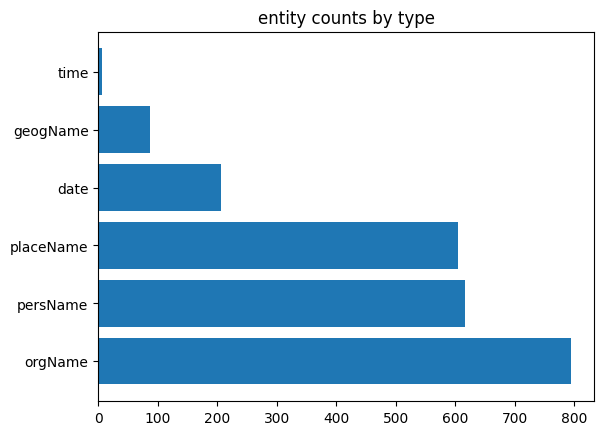

In [6]:
import matplotlib.pyplot as plt

entity_types = sorted(list(entity_type_dict.items()), key=lambda x: x[1], reverse=True)

entity_class_names = [name for name, _ in entity_types]
entity_class_counts = [count for _, count in entity_types]

plt.barh(entity_class_names, entity_class_counts)
plt.title("entity counts by type")
plt.show()

---

### Print 10 most popular entities for each type

In [7]:
print("Top 10 Named Entities by Type:")
print("==============================")
print()

for entity_type, count in entity_types:
    print(f"Entity Type: {entity_type}")
    print(f"Number of type entities: {count}")

    top_entities = sorted(
        list(entities_by_type[entity_type].items()), key=lambda x: x[1], reverse=True
    )

    for text, count in top_entities[:10]:
        print(f"{text}: {count}")
    print()

Top 10 Named Entities by Type:

Entity Type: orgName
Number of type entities: 794
ETF: 41
IRA: 37
HSA: 17
LLC: 13
Apple: 13
Google: 13
Roth IRA: 12
RRSP: 12
IRS: 11
JCI: 10

Entity Type: persName
Number of type entities: 617
salda: 18
Johnson Controls: 15
Amazon: 14
Trump: 8
Vanguard: 7
gdybyś: 7
jakbyś: 7
Uber: 7
Tyco: 7
Walmart: 6

Entity Type: placeName
Number of type entities: 605
USA: 104
Stanach Zjednoczonych: 27
Indiach: 19
Stany Zjednoczone: 12
Indie: 11
Kanadzie: 10
Wielkiej Brytanii: 9
Stanów Zjednoczonych: 8
Brazylii: 7
Indii: 7

Entity Type: date
Number of type entities: 206
1040: 9
2016 r.: 8
1099: 6
2008 roku: 6
2009: 5
2014 r.: 5
2015 r.: 4
2015 roku: 4
2015: 3
2008 r.: 3

Entity Type: geogName
Number of type entities: 87
McDonald's: 4
Boeingu: 4
europejski: 3
Scottrade: 3
Best Buy: 2
Europy: 2
Australii: 2
Ameryce Północnej: 2
europejskie: 2
Enronu: 1

Entity Type: time
Number of type entities: 6
5.: 1
godzinie 19: 1
20: 1
pierwszej w nocy: 1
siódmej rano: 1
6 rano: 1


---

### Print 50 overall most common entities

In [8]:
entity_types = sorted(list(entity_dict.items()), key=lambda x: x[1], reverse=True)

print("Top 50 Named Entities:")
print("======================")
print()

for (text, label), freq in entity_types[:50]:
    print(f"{text} ({label}): {freq}")

Top 50 Named Entities:

USA (placeName): 104
ETF (orgName): 41
IRA (orgName): 37
Stanach Zjednoczonych (placeName): 27
Indiach (placeName): 19
salda (persName): 18
HSA (orgName): 17
Johnson Controls (persName): 15
Amazon (persName): 14
LLC (orgName): 13
Apple (orgName): 13
Google (orgName): 13
Stany Zjednoczone (placeName): 12
Roth IRA (orgName): 12
RRSP (orgName): 12
IRS (orgName): 11
Indie (placeName): 11
Kanadzie (placeName): 10
JCI (orgName): 10
1040 (date): 9
Wielkiej Brytanii (placeName): 9
2016 r. (date): 8
Stanów Zjednoczonych (placeName): 8
IRR (orgName): 8
Trump (persName): 8
DHA (orgName): 8
Vanguard (persName): 7
IPO (orgName): 7
Brazylii (placeName): 7
NPV (orgName): 7
Indii (placeName): 7
kredytowego (placeName): 7
UBI (orgName): 7
amerykańskiego (placeName): 7
gdybyś (persName): 7
MBA (orgName): 7
jakbyś (persName): 7
amerykańskich (placeName): 7
Chinach (placeName): 7
Uber (persName): 7
API (orgName): 7
REIT (orgName): 7
Tyco (persName): 7
amerykańskie (placeName): 6
EI

---

### Print sentences containing entities of different types/classes

In [9]:
found_sentences = 0
for doc in processed_docs:
    for sentence in doc.sents:
        if len(sentence.ents) < 2:
            continue
        entity_label = "NONE"
        for entity in sentence.ents:
            if entity_label != entity.label_ and entity_label != "NONE":
                print("============================")
                print(sentence)
                print("\nFound entities:")
                for entity in sentence.ents:
                    print(f"{entity.text} ({entity.label_})")
                print()
                found_sentences += 1
                break
            entity_label = entity.label_
        if found_sentences >= 5:
            break
    if found_sentences >= 5:
        break

układ zobowiązanie Zobowiązanie do zapłaty Innymi słowy dług Zdefiniowana składka z drugiej strony nie tworzy takiego zobowiązania, ponieważ pracodawca jest zaangażowany tylko w mecz, który jest aktualnie opłacany Co dzieje się z Twoim kontem po wpłaceniu przez pracodawcę określonej składki (matc h)

Found entities:
Zobowiązanie (placeName)
Zdefiniowana (persName)

Z komunikatu prasowego W oparciu o cenę zamknięcia akcji Aspiro wynoszącą 0,66 SEK na dzień 29 stycznia 2015 r.,

Found entities:
Aspiro (placeName)
dzień 29 stycznia 2015 r. (date)

Kup papierosy elektroniczne w Australii za pośrednictwem Vapor Kind, wiodącego dostawcy e-papierosów i waporyzatorów w Australii.

Found entities:
Australii (placeName)
Vapor Kind (persName)
Australii (placeName)

TTIP mogłoby posunąć się do przodu nieco szybciej, a Niemcy nawet by tego nie zauważyli.

Found entities:
TTIP (persName)
Niemcy (placeName)

To jest głupie dla Rosji, ale Putin po prostu kieruje się nacjonalizmem bardziej niż jakakolw

---

### Answer the following questions:

1. Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names? - NER allows for detecting categories and is able to determine whether given world is really a named entity. Words such as "Twój", "Ciebie" or "Ty" were classified as named entities by the capital letter algorithm while NER was able to ignore them.
1. What are the drawbacks of the method based on capital letters? - As mentioned above.
1. What are the drawbacks of the method based on NER? - Couldn't find any. At least in comparison to capital letters. Of course NER is not perfect and needs to have a proper dictionary to work correctly. 
1. Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this
  observation. - Organization Names gave us the most results. Only a few results were gathered for time. Time can easily be confused with different sets of digits. Organization names are very recognizaable and often don't have any overlapping entity with the same meaning. Other possibility is that the business related topics of the texts create a bias in the dataset.
1. Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together? - They are not sufficient. We could use mapping dictionary that points to the same definite entity for several "keys" such as "USA" or "Stany Zjednoczne".
1. Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm? - Searching for potential market competitors or clients. 